# Markov Matrices Assignment  
## Nick Brown

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('GDP_cycle.csv')
df = df.rename(columns={"Unnamed: 0": "date", "GDP cycle":"GDP_cycle"})
df.head()

,date,GDP_cycle
0,1948-01-01,0.020398
1,1948-04-01,0.024427
2,1948-07-01,0.017784
3,1948-10-01,0.006505
4,1949-01-01,-0.019847


<AxesSubplot:xlabel='GDP_cycle', ylabel='Count'>

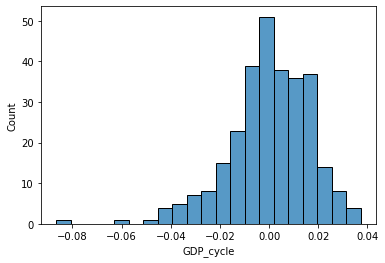

In [3]:
# histogram of data
sns.histplot(data = df, x = 'GDP_cycle')

Most of the data appears to be withing -0.02 and 0.02 for the GDP cycle.

Now it's time to create the four quantiles, add them to our dataframe, and create the consumption vector.

In [4]:
# Creating the quantiles using a Pandas function qcut
df['quant']=pd.qcut(df['GDP_cycle'],4, labels =False)
# Creating the consumption vector, using the mean of each quantile
consumption_vector = np.array(np.exp(df.groupby('quant').mean()))
consumption_vector = np.transpose(consumption_vector)
consumption_vector

array([[0.97856301, 0.99634314, 1.00618408, 1.01935352]])

In [5]:
df = df.astype({'quant': 'int64'}) # this was to make sure the quant column was integers

In [6]:
df.head() # here is what our dataframe looks like.

,date,GDP_cycle,quant
0,1948-01-01,0.020398,3
1,1948-04-01,0.024427,3
2,1948-07-01,0.017784,3
3,1948-10-01,0.006505,2
4,1949-01-01,-0.019847,0


Now I will create the M matrix using a fairly large series of if-else statements and a loop. Basically the loop and if-else statements will look at at every point in our data set and the following point and then count what transition occurs. So if one element is 1 and the next element is 2 this transition is counted by going through the if-else statements.

In [7]:
# first creating a matrix of zeros
M = np.zeros((4,4))
# now for the loop
for i in range(len(df) -1):
    if df.quant[i] == 0:
        if df.quant[i+1] == 0:
            M[0,0] += 1
        elif df.quant[i+1] == 1:
            M[0,1] += 1
        elif df.quant[i+1] == 2:
            M[0,2] += 1
        else:
            M[0,3] += 1
    elif df.quant[i] == 1:
        if df.quant[i+1] == 0:
            M[1,0] += 1
        elif df.quant[i+1] == 1:
            M[1,1] += 1
        elif df.quant[i+1] == 2:
            M[1,2] += 1
        else:
            M[1,3] += 1
    elif df.quant[i] == 2:
        if df.quant[i+1] == 0:
            M[2,0] += 1
        elif df.quant[i+1] == 1:
            M[2,1] += 1
        elif df.quant[i+1] == 2:
            M[2,2] += 1
        else:
            M[2,3] += 1
    elif df.quant[i] == 3:
        if df.quant[i+1] == 0:
            M[3,0] += 1
        elif df.quant[i+1] == 1:
            M[3,1] += 1
        elif df.quant[i+1] == 2:
            M[3,2] += 1
        else:
            M[3,3] += 1

# printing the matrix to see the raw totals for transitions
M

array([[54., 14.,  4.,  0.],
       [16., 42., 14.,  1.],
       [ 2., 15., 39., 17.],
       [ 1.,  2., 16., 54.]])

Now it's time to get this into Markov form with each row consisting of probabilities. This is achieved by dividing each element by the row sum. Will achieve this with a loop.

In [8]:
# the aforementioned loop
for i in range(M.shape[0]):
    M[i,] = M[i,] / sum(M[i,])

In [9]:
# Our Markov Matrix
M

array([[0.75      , 0.19444444, 0.05555556, 0.        ],
       [0.21917808, 0.57534247, 0.19178082, 0.01369863],
       [0.02739726, 0.20547945, 0.53424658, 0.23287671],
       [0.01369863, 0.02739726, 0.21917808, 0.73972603]])

Using Fisher code with our Markov matrix. Will see if this works (note: it works, but after I nixed the exponentiation rules Fisher gave):

In [10]:
def kern(c0,c1,rho):
    """
    This function returns an asset pricing kernel 
    c0 is current consumption
    c1 is the vector of future consumptions
    rho is the inter-temporal elasticity of substitution
    """
    if rho == 1:
        return np.true_divide(1,c1)/(1/c0) 
    else: 
        return np.power(c1,-rho)/c0**(-rho)

# Pricing Kernel
def mkern(c,beta,rho):
    n = len(c) # number of states
    K=np.zeros((n,n)) # start with an array of zeros
    for i in range (n):
        K[i,:] = beta*kern(c[i],c,rho)  # each row is an asset pricing kernel for consumption in state i
    return(K)

# Getting Price
def pricing(M,K,R):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.
    The asset returns are by column
    """
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    P = np.matmul(np.multiply(M,K), R)  
    # element by element multiplication of the pricing kernel with the markov probabilities
    return(P)


beta=0.97#**(1/4) # taking this to the 1/4 power per Fisher's instructions
# decided to not exponentiate this to the 1/4 power because the answers only line up with Fisher's when you don't
rho=2

# Not sure on how to specify R so using Fisher's R from the notes.
R = np.array([[1, 1, 0, 0, 0],
             [1,0, 1, 0, 0],
             [1, 0, 0, 1, 0],
             [1,0, 0, 0, 1]])

c = [0.98, 0.99, 1.006, 1.019] # had to create c like this because Python didn't seem to want to work otherwise

K = mkern(c,beta,rho)
p=pricing(M,K,R)
p

array([[0.96345941, 0.7275    , 0.18482003, 0.05113938, 0.        ],
       [0.9677451 , 0.21696371, 0.55808219, 0.18015708, 0.01254212],
       [0.97219652, 0.02800417, 0.20580964, 0.51821918, 0.22016353],
       [0.97818858, 0.01436631, 0.02815509, 0.21813295, 0.71753425]])

In [13]:
interest_rate = (1/p[:,0]) 
interest_rate #check my work

array([1.03792645, 1.03332995, 1.02859862, 1.02229776])

Here are the interest rates per state. Now let's get the average long term interest rate. Using Fisher's code from the February 2nd lecture.

The average interest rate is 1.0306637698283967


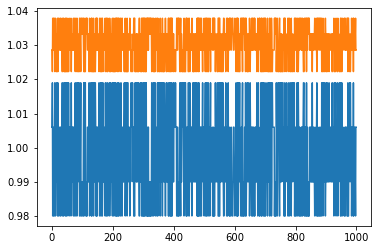

In [16]:
def ergodic(m):
    """
    This code finds the ergodic distribution of a Markov matrix
    """
    n=m.shape[0] # number of rows
    T = 1000 # useful constant
    eps=0.0001 #useful constant
    if (m.shape[0] != m.shape[1]): #test for a square matrix
        return('Matrix is not square') 
    if (not (np.matmul(m,np.ones(n))==1).all()): #test row sums 
        return('This is not a Markov matrix')
    if( not ((m >= 0).all() and (m <= 1).all())): #test probabilities
        return('This is not a Markov matrix')
    m_long = np.linalg.matrix_power(m,T)
    if( not ((m_long > 0).all() and (m_long < 1).all())): #crude test for aperiodic and irreducible
        return('This matrix may not be both aperiodic and irreducible')
    w,v = np.linalg.eig(m.T) #Need the left eigenvector; that's why we transpose
    choose = (abs(w-1) < eps)
    m_long = v[:,choose]/sum(v[:,choose])  #Need to make the eigenvector into a probability vector.
    return(m_long)

long_run = ergodic(M)  # gets the ergodic distribution of M
n=len(c) # number of states
T=1000 # time horizon
y=[] #GDP array
int_rate=[] # interest rate array
for t in range(T):
    s=np.random.choice(np.arange(0, n), p=long_run[:,0]) #choose a random state using π
    y.append(c[s])
    int_rate.append(interest_rate[s])
    
# plot the outcome
plt.plot(y)
plt.plot(int_rate)

print('The average interest rate is', np.mean(int_rate))

Was able to get the same long term interest rate as Fisher after I didn't exponentiate $\beta^{1/4}$ and then didn't exponentiate the interest rates to the fourth power. Otherwise my interest rates were extremely low, basically zero. Not sure what the issue was there. Nonetheless was able to achieve the 3% interest rate Fisher wanted.